<a href="https://colab.research.google.com/github/weix0026/InventoryManagement/blob/main/options.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


<ipython-input-4-d10f22b7624b>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  opt = pd.DataFrame().append(opt.calls).append(opt.puts)
<ipython-input-4-d10f22b7624b>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(opt, ignore_index=True)
<ipython-input-4-d10f22b7624b>:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  opt = pd.DataFrame().append(opt.calls).append(opt.puts)
<ipython-input-4-d10f22b7624b>:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  options = options.append(opt, ignore_index=True)
<ipython-input-4-d10f22b7624b>:26: FutureWarning: The frame.append method is deprecated and will be removed fr

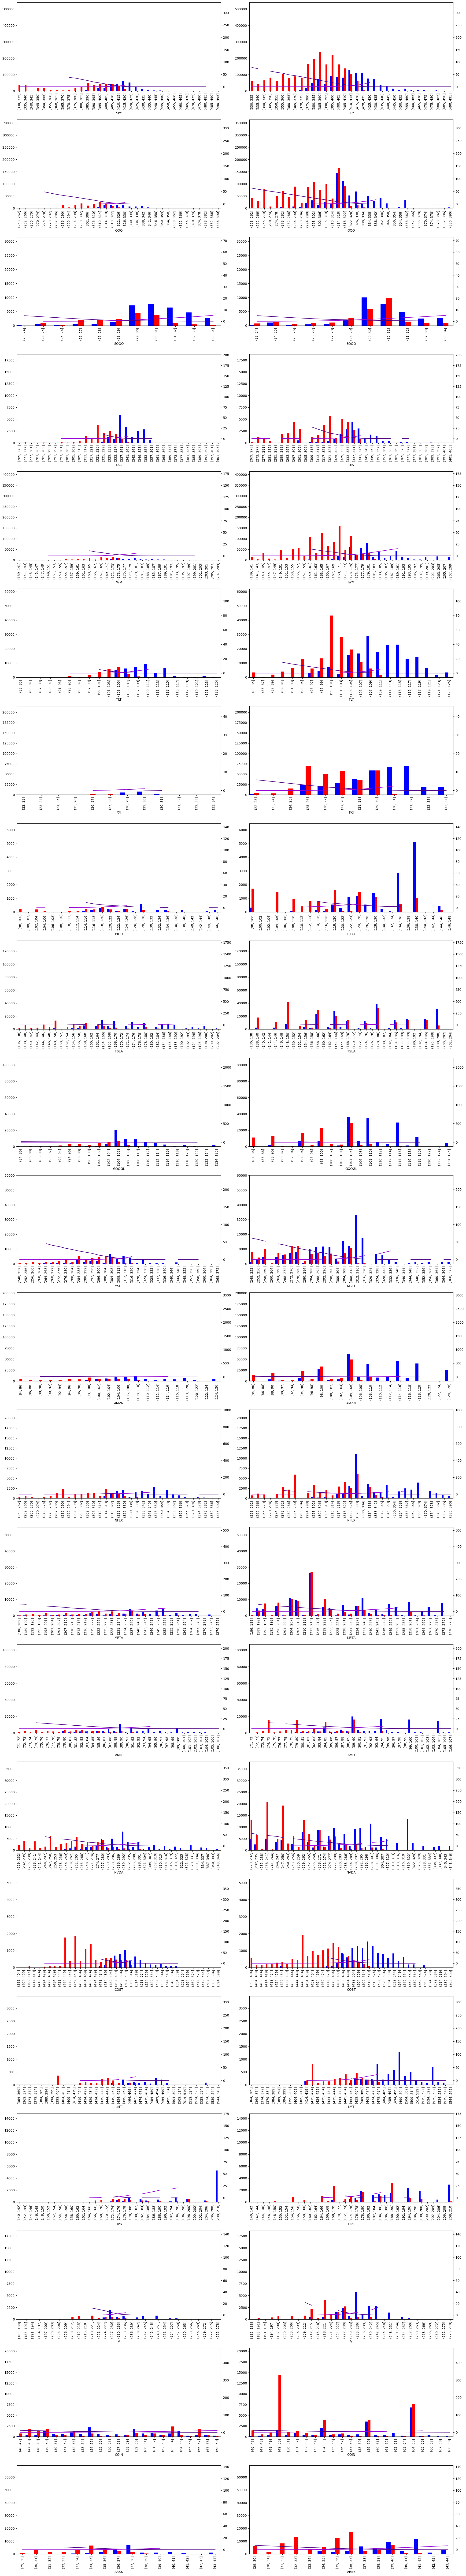

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from pytz import timezone
from dateutil.relativedelta import relativedelta
from google.colab import drive
from csv import writer
from matplotlib import pyplot as plt

mountain = timezone('US/Mountain')

currentDatetime = datetime.datetime.now(mountain)
drive.mount('/content/gdrive')
strToday = (str(currentDatetime.year)+"_"+str(currentDatetime.month) + "_"  
              +str(currentDatetime.day))

def options_chain(symbol):
  tk = yf.Ticker(symbol)
  # Expiration dates
  exps = tk.options
  # Get options for each expiration
  options = pd.DataFrame()
  for e in exps:
      opt = tk.option_chain(e)
      opt = pd.DataFrame().append(opt.calls).append(opt.puts)
      opt['expirationDate'] = e
      options = options.append(opt, ignore_index=True)

  options['expirationDate'] = pd.to_datetime(options['expirationDate']) 
  options['dte'] = (options['expirationDate'] - datetime.datetime.today()).dt.days / 365
  # Boolean column if the option is a CALL
  options['CALL'] = options['contractSymbol'].str[4:].apply(
      lambda x: "C" in x)
  options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
  options['mark'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask
  # Drop unnecessary and meaningless columns
  options = options.drop(columns = ['currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])
  return options

predictedVar_list = ['SPY','QQQ','SQQQ','DIA','IWM','TLT',
                     'FXI','BIDU',
                     'TSLA','GOOGL','MSFT','AMZN','NFLX','META',
                     'AMD','NVDA',
                     'COST','LMT','UPS','V',
                     'COIN','ARKK'
                     ]

closing_prices = {}

# Loop through the stocks in the list and get the closing price for each one
for stock in predictedVar_list:
    ticker = yf.Ticker(stock)
    history = ticker.history(period='1d')
    closing_price = history['Close'][-1]
    closing_prices[stock] = closing_price

historyRecord_dir = '/content/gdrive/My Drive/Investment/Tables/OptionTables'
historyFigure_dir = '/content/gdrive/My Drive/Investment/Figures/OptionFigures'

for predictedVar in predictedVar_list:  
  optionTable= options_chain(predictedVar)
  optionTable= optionTable.fillna(0)  
  with open(f"{historyRecord_dir}/option" + str(strToday) + predictedVar + ".csv", mode='w') as f:
    optionTable.to_csv(f, index=False, header=True) 

def create_bins(lower_bound, upper_bound, numbins):
    bins = []
    width=(upper_bound-lower_bound)//numbins+1
    for low in range(int(lower_bound), int(upper_bound+width), int(width)):
        bins.append(int(low))
    return bins

num_tickers = len(predictedVar_list)
num_col = 2
num_row = num_tickers

indexRow =0
indexCol =0
n_bins = 40
maxPriceLimit = 800

fig, axes = plt.subplots(num_row, num_col, figsize=(20, 5*num_row))
expirationDates = ["2023-05-12", "2023-05-19"]

# Read and analyze today's option
for predictedVar in predictedVar_list: 
  hist_option = pd.read_csv(f"{historyRecord_dir}/option" + str(strToday) + predictedVar + ".csv")
  tempbins = create_bins(closing_prices[predictedVar]*0.9, closing_prices[predictedVar]*1.1, n_bins)

  yaxislimit = hist_option.groupby([pd.cut(hist_option['strike'],tempbins)])[['openInterest']].sum().reset_index().openInterest.max()/len(expirationDates)
  y2axislimit = hist_option['mark'].max()

  hist_option['expirationDate'] = pd.to_datetime(hist_option['expirationDate'])
  mybins = create_bins(closing_prices[predictedVar]*0.8, closing_prices[predictedVar]*1.2, n_bins)
  
  for dateExpire in expirationDates:
    optionsInDate = hist_option.loc[hist_option['expirationDate'] == dateExpire]
    optionsInDate = optionsInDate.loc[(hist_option['openInterest'] >= 50)] #& (hist_option['strike'] <= maxPriceLimit)]
    #optionsInDate_sum = optionsInDate.groupby([pd.cut(optionsInDate['strike'],mybins)])[['openInterest']].sum().reset_index()
    #sc1=optionsInDate_sum.plot(ax = axes[indexRow, indexCol], kind ='bar', x='strike', y='openInterest', rot=90)

    optionsInDatePut = optionsInDate.loc[optionsInDate.CALL == False]
    optionsInDateCall = optionsInDate.loc[optionsInDate.CALL == True]
    optionsInDate_sum_call = optionsInDateCall.groupby([pd.cut(optionsInDateCall['strike'],mybins)])[['openInterest']].sum().reset_index()
    optionsInDate_sum_put = optionsInDatePut.groupby([pd.cut(optionsInDatePut['strike'],mybins)])[['openInterest']].sum().reset_index()

    optionsInDate_median_call = optionsInDateCall.groupby([pd.cut(optionsInDateCall['strike'],mybins)])[['mark']].median().reset_index()
    optionsInDate_median_put = optionsInDatePut.groupby([pd.cut(optionsInDatePut['strike'],mybins)])[['mark']].median().reset_index()
   
    sc1=optionsInDate_sum_call.plot(width=0.3, position=1.5, ax = axes[indexRow, indexCol], kind ='bar', x='strike', y='openInterest', color = 'b', rot=90)
    sc2=optionsInDate_sum_put.plot(width=0.3, position=0.5, ax = axes[indexRow, indexCol], kind ='bar', x='strike', y='openInterest', color = 'r', rot=90)

    ax3 = optionsInDate_median_call.plot(secondary_y=True, ax=axes[indexRow, indexCol], marker="", x='strike', y='mark', color = 'indigo', rot=90)
    ax4 = optionsInDate_median_put.plot(secondary_y=True, ax=axes[indexRow, indexCol], marker="", x='strike', y='mark', color = 'darkviolet', rot=90)

    axes[indexRow, indexCol].set(xlabel=predictedVar)
    axes[indexRow, indexCol].set_ylim([0, yaxislimit])
    axes[indexRow, indexCol].right_ax.set_ylim([-y2axislimit/20,y2axislimit])
    axes[indexRow, indexCol].get_legend().remove()

    indexCol = indexCol+1

  indexCol=0
  indexRow= indexRow+1

plt.tight_layout()
fig.savefig(f"{historyFigure_dir}/option" + str(strToday) + predictedVar + ".png")

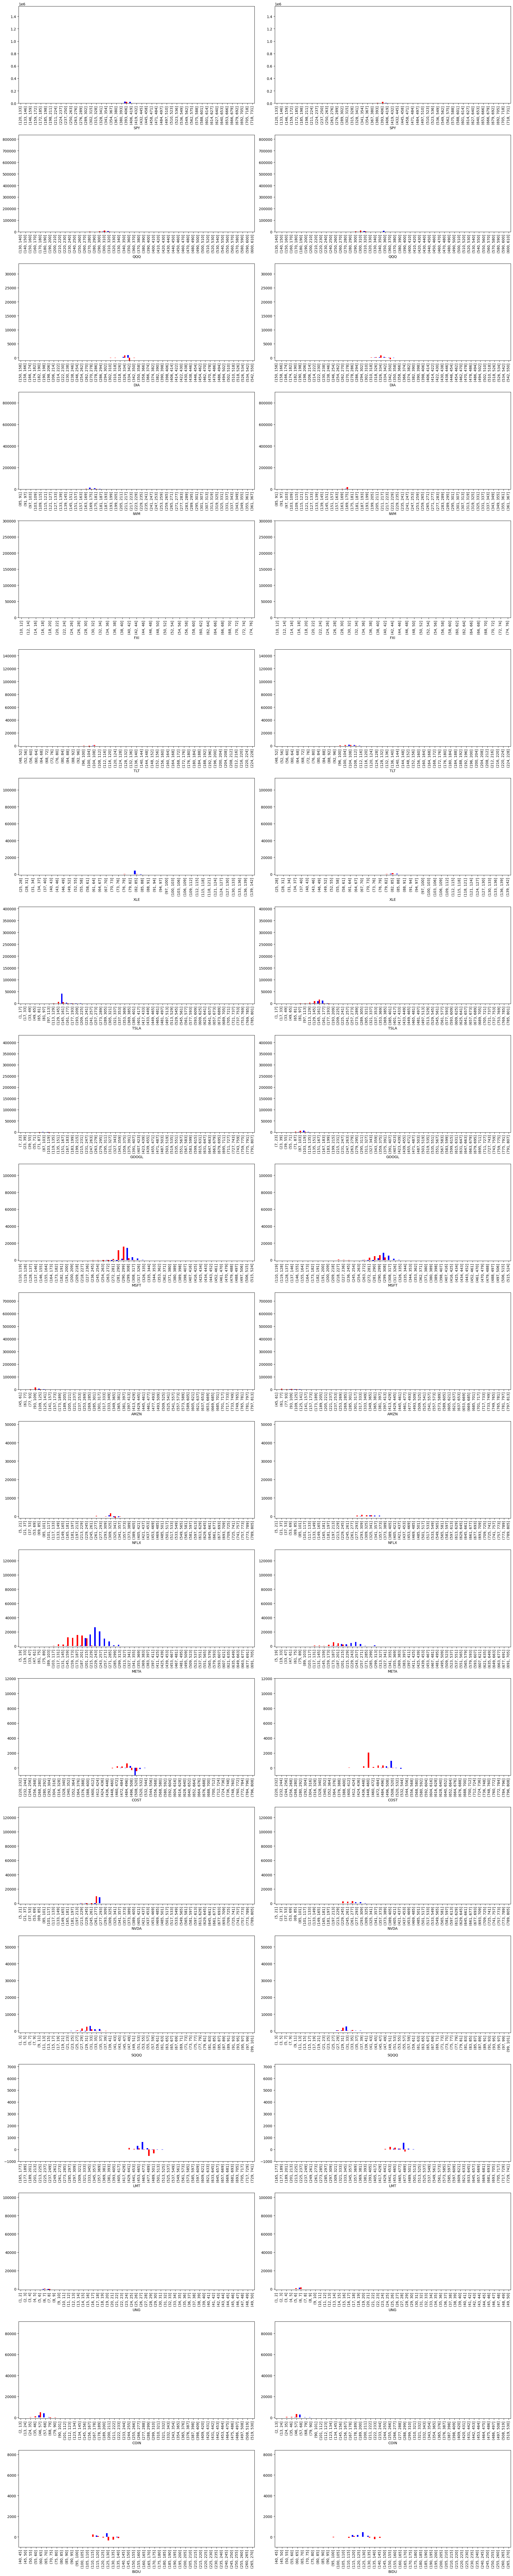

In [ ]:
# Compare options from the last time it is recorded

num_col = 2
num_row = num_tickers

indexRow =0
indexCol =0
n_bins = 50
maxPriceLimit = 800

fig, axes = plt.subplots(num_row, num_col, figsize=(20, 5*num_row))

str_later_day = '2023_4_27'
str_earlier_day = '2023_5_6'

for predictedVar in predictedVar_list:  
  hist_option_later = pd.read_csv(f"{historyRecord_dir}/option" + str(str_later_day) + predictedVar + ".csv")
  tempbins = create_bins(hist_option_later['strike'].min(), min(hist_option_later['strike'].max(), maxPriceLimit), n_bins)
  
  hist_option_earlier = pd.read_csv(f"{historyRecord_dir}/option" + str(str_earlier_day) + predictedVar + ".csv")
  
  yaxislimit = hist_option_later.groupby([pd.cut(hist_option_later['strike'],tempbins)])[['openInterest']].sum().reset_index().openInterest.max()/len(expirationDates)

  hist_option_later['expirationDate'] = pd.to_datetime(hist_option_later['expirationDate'])
  mybins = create_bins(hist_option_later['strike'].min(), min(hist_option_later['strike'].max(), maxPriceLimit), n_bins)
  
  for dateExpire in expirationDates:
    optionsInDate_later = hist_option_later.loc[hist_option_later['expirationDate'] == dateExpire]
    optionsInDate_later = optionsInDate_later.loc[(hist_option_later['openInterest'] >= 50) & (hist_option_later['strike'] <= maxPriceLimit)]

    optionsInDatePut_later = optionsInDate_later.loc[optionsInDate_later.CALL == False]
    optionsInDateCall_later = optionsInDate_later.loc[optionsInDate_later.CALL == True]
    optionsInDate_sum_call_later = optionsInDateCall_later.groupby([pd.cut(optionsInDateCall_later['strike'],mybins)])[['openInterest']].sum().reset_index()
    optionsInDate_sum_put_later = optionsInDatePut_later.groupby([pd.cut(optionsInDatePut_later['strike'],mybins)])[['openInterest']].sum().reset_index()
   
    optionsInDate_earlier = hist_option_earlier.loc[hist_option_earlier['expirationDate'] == dateExpire]
    optionsInDate_earlier = optionsInDate_earlier.loc[(hist_option_earlier['openInterest'] >= 50) & (hist_option_earlier['strike'] <= maxPriceLimit)]

    optionsInDatePut_earlier = optionsInDate_earlier.loc[optionsInDate_earlier.CALL == False]
    optionsInDateCall_earlier = optionsInDate_earlier.loc[optionsInDate_earlier.CALL == True]
    optionsInDate_sum_call_earlier = optionsInDateCall_earlier.groupby([pd.cut(optionsInDateCall_earlier['strike'],mybins)])[['openInterest']].sum().reset_index()
    optionsInDate_sum_put_earlier = optionsInDatePut_earlier.groupby([pd.cut(optionsInDatePut_earlier['strike'],mybins)])[['openInterest']].sum().reset_index()

    optionsInDateCall_merged = pd.merge(optionsInDate_sum_call_earlier, optionsInDate_sum_call_later, on=['strike'], how='inner',suffixes=('_e', '_l'))
    optionsInDatePut_merged = pd.merge(optionsInDate_sum_put_earlier, optionsInDate_sum_put_later, on=['strike'], how='inner',suffixes=('_e', '_l'))
    
    optionsInDateCall_merged['diff'] = optionsInDateCall_merged['openInterest_l']-optionsInDateCall_merged['openInterest_e']
    optionsInDatePut_merged['diff'] = optionsInDatePut_merged['openInterest_l']-optionsInDatePut_merged['openInterest_e']
    
    sc1=optionsInDateCall_merged.plot(width=0.3, position=1.5, ax = axes[indexRow, indexCol], kind ='bar', x='strike', y='diff', color = 'b', rot=90)
    sc2=optionsInDatePut_merged.plot(width=0.3, position=0.5, ax = axes[indexRow, indexCol], kind ='bar', x='strike', y='diff', color = 'r', rot=90)

    axes[indexRow, indexCol].set(xlabel=predictedVar)
    axes[indexRow, indexCol].set_ylim([-1000, yaxislimit])
    axes[indexRow, indexCol].get_legend().remove()
    

    indexCol = indexCol+1

  indexCol=0
  indexRow= indexRow+1

plt.tight_layout()
fig.savefig(f"{historyFigure_dir}/option_diff_" + str(strToday) + predictedVar + ".png")
